Attcking notebook

In [24]:
import logging
import pathlib
import random
import shutil
import time
import os
import sys

import numpy as np
import torch
import torchvision
from tensorboardX import SummaryWriter
from torch.nn import functional as F
from torch.utils.data import DataLoader
from common.args import Args
from data import transforms
import matplotlib

matplotlib.use('Agg')
import matplotlib.pyplot as plt
from models.subsampling_model import Subsampling_Model
from scipy.spatial import distance_matrix
from tsp_solver.greedy import solve_tsp
import scipy.io as sio
from common.utils import get_vel_acc
from common.evaluate import psnr, ssim
from fastmri.losses import SSIMLoss
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

import matplotlib.pyplot as plt

In [25]:
import torch
from torch import nn
from torch.nn import functional as F

import fastmri.models
from models.rec_models.unet_model import UnetModel
from models.rec_models.complex_unet import ComplexUnetModel
import data.transforms as transforms
from pytorch_nufft.nufft import nufft, nufft_adjoint
import numpy as np
from WaveformProjection.run_projection import proj_handler
import matplotlib.pylab as P
from models.rec_models.vision_transformer import VisionTransformer
from models.rec_models.recon_net import ReconNet
from models.rec_models.humus_net import HUMUSNet, HUMUSBlock
from  models.VarBlock import VarNet
from typing import Tuple
from fastmri.data.subsample import create_mask_for_mask_type
from fastmri.data.transforms import apply_mask

import torch
import numpy as np

In [26]:
import torch
if torch.cuda.is_available():
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA device not available")

CUDA Device Name: NVIDIA TITAN Xp


In [27]:
torch.cuda.empty_cache()

In [121]:
import pathlib
import random
import h5py
from torch.utils.data import Dataset
import torch

class SliceData(Dataset):
    def __init__(self, root, transform, challenge="singlecoil", sample_rate=1, resolution=(320, 320)):
        """
        Args:
            root (pathlib.Path): Path to the dataset.
            transform (callable): A callable object that pre-processes the raw data into
                appropriate form. The transform function should take 'kspace', 'target',
                'attributes', 'filename', and 'slice' as inputs. 'target' may be null
                for test data.
            challenge (str): "singlecoil" or "multicoil" depending on which challenge to use.
            sample_rate (float, optional): A float between 0 and 1. This controls what fraction
                of the volumes should be loaded.
        """
        assert challenge in ["singlecoil", "multicoil"], "Challenge must be 'singlecoil' or 'multicoil'"
        self.transform = transform
        self.challenge = challenge
        self.examples = []

        files = list(pathlib.Path(root).iterdir())
        if sample_rate < 1:
            random.shuffle(files)
            num_files = round(len(files) * sample_rate)
            files = files[:num_files]

        for fname in sorted(files):
            try:
                with h5py.File(fname, 'r') as data:
                    if "kspace" not in data:
                        continue  # Skip files without k-space data

                    kspace = data["kspace"]
                    if self.challenge == "multicoil":
                        if len(kspace.shape) != 4:  # Ensure it follows (num_slices, num_coils, height, width)
                            continue
                    else:
                        if len(kspace.shape) != 3:  # Ensure it follows (num_slices, height, width)
                            continue

                    num_slices = kspace.shape[0]
                    self.examples += [(fname, slice) for slice in range(5, num_slices - 2)]
            except Exception as e:
                print(f"Skipping {fname} due to error: {e}")
                continue

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        fname, slice = self.examples[i]
        with h5py.File(fname, 'r') as data:
            kspace = data["kspace"][slice]

            # Target selection
            if "reconstruction_rss" in data:
                target = data["reconstruction_rss"][slice]
            elif "reconstruction_esc" in data and self.challenge == "singlecoil":
                target = data["reconstruction_esc"][slice]
            else:
                target = None  # Test data may not have targets

            return self.transform(kspace, target, data.attrs, fname.name, slice)

In [122]:
class DataTransform:
    def __init__(self, resolution):
        self.resolution = resolution

    def __call__(self, kspace, target, attrs, fname, slice):
        kspace = transforms.to_tensor(kspace)
        #print("kspace: ",kspace.shape)
        image = transforms.ifft2_regular(kspace)
        image = transforms.complex_center_crop(image, (self.resolution, self.resolution))
        image, mean, std = transforms.normalize_instance(image, eps=1e-11)
        target = transforms.to_tensor(target)
        target, mean, std = transforms.normalize_instance(target, eps=1e-11)
        # # target = transforms.normalize(target, mean, std)
        # target = target.clamp(-6, 6)
        mean = std = 0

        if target.shape[1] != self.resolution:
            target = transforms.center_crop(target, (self.resolution, self.resolution))
        return image.mean(0) , target, mean, std, attrs['norm'].astype(np.float32)


def create_knee_dataset(args):
    dev_data = SliceData(
        root="/datasets/4VISTA/fastmri_knee/singlecoil_val",
        transform=DataTransform(args.resolution),
        sample_rate=args.sample_rate)
    return dev_data

def create_datasets(args):
    print(args.data_path / f'multicoil_test', flush=True)
    dev_data = SliceData(
        root=args.data_path / f'multicoil_test',
        transform=DataTransform(args.resolution),
        sample_rate=args.sample_rate)

    return dev_data

def create_data_loaders(args, knee = False):
    dev_data = create_datasets(args) if not knee else create_knee_dataset(args)
    dev_loader = DataLoader(
        dataset=dev_data,
        batch_size=args.batch_size,
        num_workers=20,
        pin_memory=True,
    )
    return dev_loader

In [123]:
import torch
import torch.nn.functional as F
import numpy as np
import time
from tqdm import tqdm

def evaluate(args, epoch, model, data_loader):
    model.eval()
    losses = []
    psnr_l = []
    ssim_l = []

    start = time.perf_counter()
    with torch.no_grad():
        if epoch > 0:
            progress_bar = tqdm(enumerate(data_loader), total=len(data_loader), desc=f"Evaluating Epoch {epoch}")
            
            for iter, data in progress_bar:
                input, target, mean, std, norm = data
                input = input.to(args.device)
                resolution = target.shape[-1]
                target = target.to(args.device)

                output = model(input.unsqueeze(1))
                recons = output.to('cpu').squeeze(1).view(target.shape)
                recons = recons.squeeze()
                if output.shape != target.shape:
                    target = target.view_as(output)

                loss = F.l1_loss(output, target)
                losses.append(loss.item())

                target = target.view(-1, resolution, resolution)
                recons = recons.view(target.shape)

                psnr_value = psnr(target.to('cpu').numpy(), recons.numpy())
                ssim_value = ssim(target.to('cpu').numpy(), recons.numpy())
                psnr_l.append(psnr_value)
                ssim_l.append(ssim_value)

                # Update tqdm progress bar with current metrics
                progress_bar.set_postfix({
                    "Loss": f"{loss.item():.4f}",
                    "PSNR": f"{psnr_value:.2f}",
                    "SSIM": f"{ssim_value:.4f}"
                })

        print(f'PSNR: {np.mean(psnr_l):.2f} ± {np.std(psnr_l):.2f}, SSIM: {np.mean(ssim_l):.4f} ± {np.std(ssim_l):.4f}')
        
        x = model.module.get_trajectory()
        v, a = get_vel_acc(x)
        acc_loss = torch.sqrt(torch.sum(torch.pow(F.softshrink(a, args.a_max), 2)))
        vel_loss = torch.sqrt(torch.sum(torch.pow(F.softshrink(v, args.v_max), 2)))
        rec_loss = np.mean(losses)

        return np.mean(losses), np.mean(psnr_l), np.mean(ssim_l), np.std(psnr_l), np.std(ssim_l)

In [119]:
def build_model(args):
    print(f"reconstructing : {args.model}")
    model = Subsampling_Model(
        in_chans=args.in_chans,
        out_chans=args.out_chans,
        chans=args.num_chans,
        num_pool_layers=args.num_pools,
        drop_prob=args.drop_prob,
        decimation_rate=args.decimation_rate,
        res=args.resolution,
        trajectory_learning=args.trajectory_learning,
        initialization=args.initialization,
        SNR=args.SNR,
        n_shots=args.n_shots,
        interp_gap= args.interp_gap,
        type=args.model,
        img_size=args.img_size,
        window_size=args.window_size,
        embed_dim=args.embed_dim,
        num_blocks=args.num_blocks,
        sample_per_shot=args.sample_per_shot
    ).to(args.device)
    return model

def load_model(checkpoint_file):
    print(checkpoint_file)
    checkpoint = torch.load(checkpoint_file)
    args = checkpoint['args']
    model = build_model(args)
    if args.data_parallel:
        model = torch.nn.DataParallel(model)
    model.load_state_dict(checkpoint['model'])
    optimizer = build_optim(args, model)
    optimizer.load_state_dict(checkpoint['optimizer'])
    return checkpoint, model, optimizer, args

def build_optim(args, model):
    optimizer = torch.optim.Adam([{'params': model.module.subsampling.parameters(), 'lr': args.sub_lr},
                                  {'params': model.module.reconstruction_model.parameters()}], args.lr)
    return optimizer

In [88]:
checkpoint_files = {
    "Unet_with_trajectory_learning": """/home/mohammed-wa/PycharmProjects/MPILOT/summary/16/radial_0.0005_0.075_0.001_0.001_changing_downwards_10_Unet/model.pt""",
    "Unet_with_trajectory_learning_with_PGD_Train_3norm" : "/home/mohammed-wa/PycharmProjects/MPILOT/summary/16//radial_0.0005_0.075_0.001_0.001_changing_downwards_10_Unet_random_PGD_noise_steps10_start_epsilon3_noise_typelinf_P0.5/model.pt",
}

In [89]:
_, Unet_with_trajectory_learning, _, args_Unet_with_trajectory_learning = load_model(checkpoint_files["Unet_with_trajectory_learning"])
_, Unet_with_trajectory_learning_with_PGD_Train_3norm, _, args_Unet_with_trajectory_learning_with_constant_noise_10000_l1_5 = load_model(checkpoint_files["Unet_with_trajectory_learning_with_PGD_Train_3norm"])
args = args_Unet_with_trajectory_learning

/home/mohammed-wa/PycharmProjects/MPILOT/summary/16/radial_0.0005_0.075_0.001_0.001_changing_downwards_10_Unet/model.pt
reconstructing : Unet
3001
0
/home/mohammed-wa/PycharmProjects/MPILOT/summary/16//radial_0.0005_0.075_0.001_0.001_changing_downwards_10_Unet_random_PGD_noise_steps10_start_epsilon3_noise_typelinf_P0.5/model.pt
reconstructing : Unet
3001
0


In [90]:
args.seed
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)

In [93]:
def plot_trajectory(x):
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    ax.axis([-165, 165, -165, 165])
    for i in range(x.shape[0]):
        ax.plot(x[i, :, 0], x[i, :, 1])
    return fig

def show_trajectory(model):
    %matplotlib inline
    import matplotlib
    import matplotlib.pyplot as plt

    x = model.module.get_trajectory()
    fig = plot_trajectory(x.detach().cpu().numpy())
    plt.show()

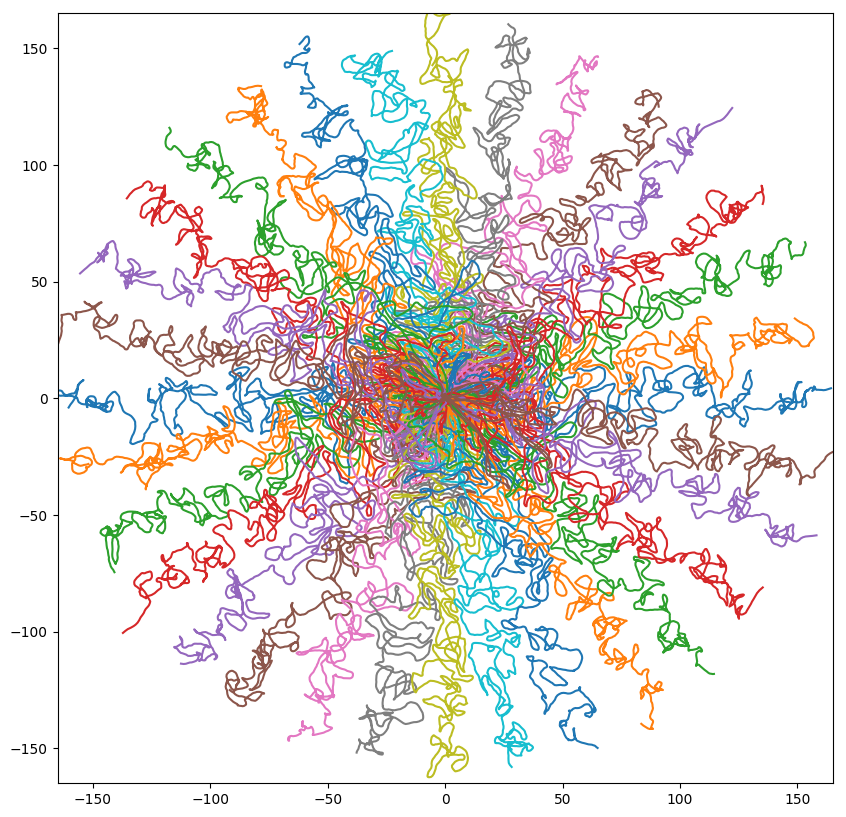

In [94]:
show_trajectory(Unet_with_trajectory_learning)

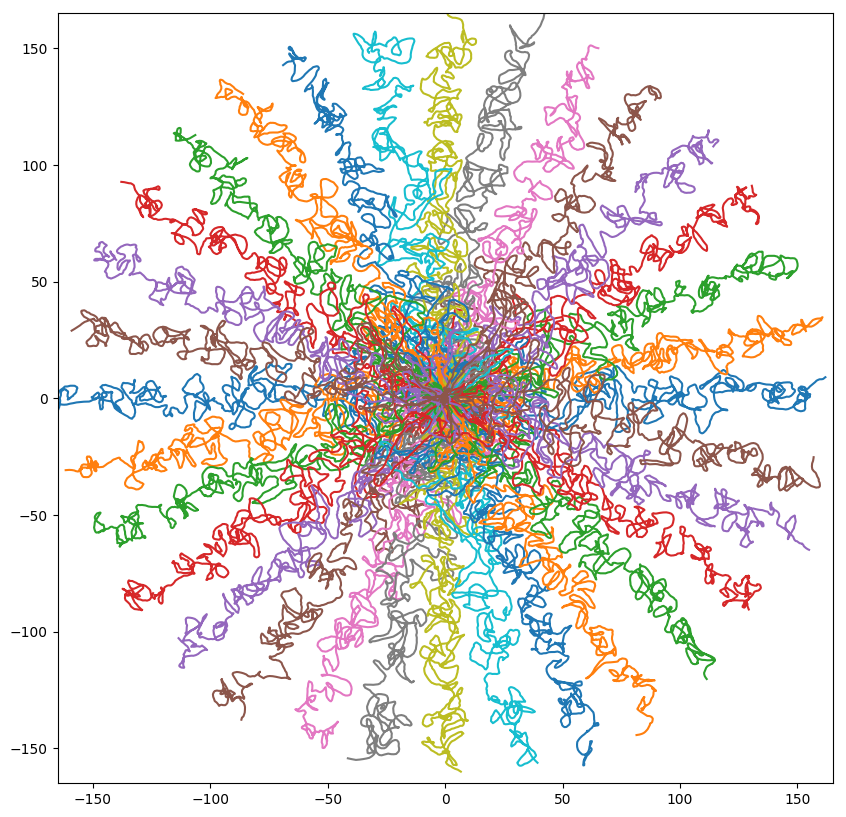

In [95]:
show_trajectory(Unet_with_trajectory_learning_with_PGD_Train_3norm)

In [124]:
knee_loader = create_data_loaders(args,True)

CORPD_FBK:  <KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']>
CORPD_FBK:  <KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']>
CORPD_FBK:  <KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']>
CORPD_FBK:  <KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']>
CORPD_FBK:  <KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']>
CORPD_FBK:  <KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']>
CORPD_FBK:  <KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']>
CORPD_FBK:  <KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']>
CORPD_FBK:  <KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']>
CORPD_FBK:  <KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']>


In [125]:
len(knee_loader)

290

In [127]:
first_batch = next(iter(knee_loader))

In [129]:
first_element = first_batch[0]

In [131]:
first_element.shape

torch.Size([10, 320, 2])

In [44]:
len(knee_loader.dataset)

1030

In [79]:
args_Unet_with_trajectory_learning.sample_rate = 1
args_Unet_with_trajectory_learning.batch_size = 10

dev_loader = create_data_loaders(args)

/home/mohammed-wa/PycharmProjects/MPILOT/Datasets/pd_only/multicoil_test
AXT1POST:  <KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_rss']>
AXT1POST:  <KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_rss']>
AXT1POST:  <KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_rss']>
AXT1POST:  <KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_rss']>
AXT1POST:  <KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_rss']>
AXT1POST:  <KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_rss']>
AXT1POST:  <KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_rss']>
AXT1POST:  <KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_rss']>
AXT1POST:  <KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_rss']>
AXT1POST:  <KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_rss']>
AXT1POST:  <KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_rss']>
AXT1POST:  <KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_rss']>
AXT

In [126]:
evaluate(args_Unet_with_trajectory_learning, 1, Unet_with_trajectory_learning, knee_loader)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fefbd3bb3b0>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fefbd3bb3b0>Exception ignored in:   File "/home/mohammed-wa/miniconda3/envs/mpilot/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__

Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7fefbd3bb3b0>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fefbd3bb3b0>self._shutdown_workers()

  File "/home/mohammed-wa/miniconda3/envs/mpilot/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__

Exception ignored in: Exception ignored in: Traceback (most recent call last):
Exception ignored in:   File "/home/mohammed-wa/miniconda3/envs/mpilot/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
Traceback (most recent call last):
<function _M

RuntimeError: number of dims don't match in permute

In [98]:
evaluate(args_Unet_with_trajectory_learning, 1, Unet_with_trajectory_learning_with_PGD_Train_3norm, dev_loader)

Evaluating Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:47<00:00,  1.10it/s, Loss=0.1227, PSNR=24.97, SSIM=0.8539]

PSNR: 27.34 ± 1.55, SSIM: 0.8283 ± 0.0292


(0.17353492917922828,
 27.33690348833579,
 0.828259788760379,
 1.551003897081583,
 0.029168569121553366)

In [256]:
x = Unet_with_trajectory_learning.module.get_trajectory()
v, a = get_vel_acc(x)
acc_loss = torch.sqrt(torch.sum(torch.pow(F.softshrink(a, args_Unet_with_trajectory_learning.a_max).abs() + 1e-8, 2)))
vel_loss = torch.sqrt(torch.sum(torch.pow(F.softshrink(v, args_Unet_with_trajectory_learning.v_max).abs() + 1e-8, 2)))

In [257]:
vel_loss, acc_loss

(tensor(1.0481, device='cuda:0', grad_fn=<SqrtBackward>),
 tensor(84.3785, device='cuda:0', grad_fn=<SqrtBackward>))

In [258]:
import torch
import torch.nn.functional as F
from tqdm import tqdm  

optimizer = torch.optim.Adam(Unet_with_trajectory_learning_with_constant_noise_10000_l1_2.module.parameters(), lr=1e-1)

a_max, v_max = args_Unet_with_trajectory_learning.a_max, args_Unet_with_trajectory_learning.v_max

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100, verbose=True)

with tqdm(desc="Training Iterations", ncols=100, leave=True) as pbar:
    iteration = 0
    while True: 
        optimizer.zero_grad() 

        x = Unet_with_trajectory_learning_with_constant_noise_10000_l1_2.module.get_trajectory()

        v, a = get_vel_acc(x)

        # Compute acceleration and velocity losses
        acc_loss = torch.sqrt(torch.sum(torch.pow(F.softshrink(a, a_max).abs() + 1e-8, 2)))
        vel_loss = torch.sqrt(torch.sum(torch.pow(F.softshrink(v, v_max).abs() + 1e-8, 2)))

        # Total loss
        loss = acc_loss + vel_loss

        # Backpropagate
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Update the progress bar description with current loss
        pbar.set_postfix(loss=acc_loss.item())

        # Update progress bar
        pbar.update(1)

        # Check if loss is less than the desired threshold
        if acc_loss.item() < 5*1e-5 and vel_loss.item() < 1e-5:
            print(f"acc_loss reached {acc_loss.item()} at iteration {iteration + 1}. Stopping training.")
            break

        # Step the scheduler to adjust the learning rate based on the loss
        scheduler.step(loss)

        # Increment the iteration
        iteration += 1

    print("Training completed!")


NameError: name 'Unet_with_trajectory_learning_with_constant_noise_10000_l1_2' is not defined

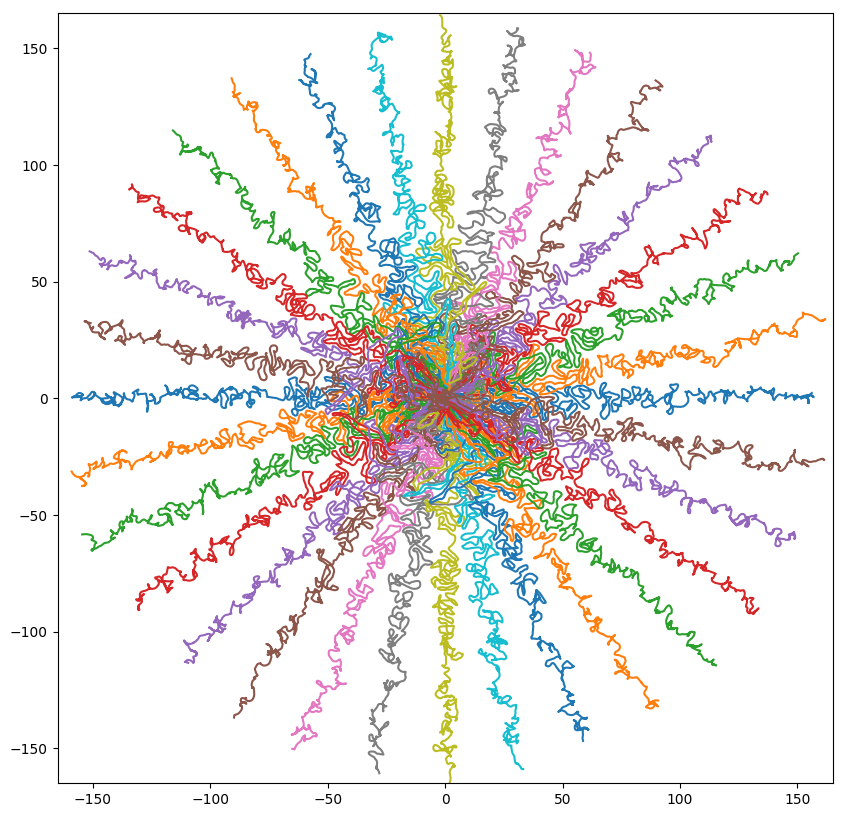

In [259]:
show_trajectory(Unet_with_trajectory_learning)

In [260]:
def get_first_example(dataloader):
    """
    Get the first example from the DataLoader without iteration.

    Args:
    - dataloader: PyTorch DataLoader object

    Returns:
    - first_input: The first input example in the dataset.
    - first_label: The label for the first input example.
    """
    inputs, labels, _, _, _ = next(iter(dataloader))
    first_input = inputs[0]
    first_target = labels[0]
    
    return first_input, first_target

In [261]:
first_input, first_target = get_first_example(dev_loader)

In [262]:
first_input = first_input.unsqueeze(0).unsqueeze(0)

In [28]:
first_input.shape

torch.Size([1, 1, 320, 320, 2])

In [29]:
first_input.to("cuda")
first_target.to("cuda")

tensor([[-0.5698, -0.6040, -0.5868,  ..., -0.6260, -0.6496, -0.5314],
        [-0.6575, -0.6569, -0.6336,  ..., -0.5878, -0.6289, -0.6277],
        [-0.5810, -0.5913, -0.5449,  ..., -0.5896, -0.6098, -0.6167],
        ...,
        [-0.6167, -0.5718, -0.6231,  ..., -0.6044, -0.6758, -0.6511],
        [-0.5978, -0.6065, -0.6446,  ..., -0.6178, -0.6312, -0.5892],
        [-0.6151, -0.5819, -0.5838,  ..., -0.5859, -0.6180, -0.6133]],
       device='cuda:0')

In [263]:
import torch
import torchvision
import matplotlib.pyplot as plt
import os
from torchvision.transforms import Resize, ToPILImage

def show_image(source):
    source = source.clone()
    source.reshape(320,320)
    image = source
    image -= image.min()
    max_val = image.max()
    if max_val > 0:
        image /= max_val
    source = image
    grid = torchvision.utils.make_grid(source, nrow=4, pad_value=1)
    numpy_image = grid.permute(1, 2, 0).cpu().detach().numpy()

    # Save or display the image
    plt.imshow(numpy_image)
    plt.axis('off')
    plt.show()


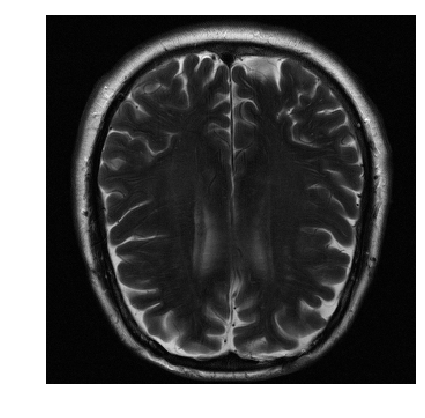

In [264]:
show_image(first_target)

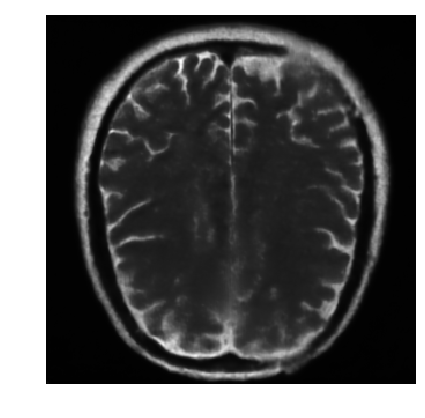

In [265]:
show_image(Unet_with_trajectory_learning(first_input))

In [266]:
import torch
import torch.nn.functional as F
from tqdm import tqdm  # Import tqdm for progress bar
from fastmri.losses import SSIMLoss

def pgd_attack_with_trajectory(model, input_tensor, target_tensor, epsilon, steps=20):
    if input_tensor.dim() < 5:
        input_tensor = input_tensor.view(*([1] * (5 - input_tensor.dim())), *input_tensor.shape)
    
    initial_trajectory = model.module.subsampling.x.detach().clone() 
    trajectory_param = model.module.subsampling.x
    trajectory_param.requires_grad = True  
    

    output = model(input_tensor)
    if output.shape != target_tensor.shape:
        target_tensor = target_tensor.view_as(output)
        
    init_psnr = psnr(target_tensor.to('cpu').numpy(), output.cpu().detach().numpy())
    lowest_psnr = float('inf')
    best_trajectory = initial_trajectory.clone().data.detach()
    
    for step in range(steps):
        if model.module.subsampling.x.grad != None:
            model.module.subsampling.x.grad.zero_()
        
        output = model(input_tensor)
        if output.shape != target_tensor.shape:
            target_tensor = target_tensor.view_as(output)
            
        loss = F.l1_loss(output.to("cpu"), target_tensor.to("cpu"))
        psnr_value = psnr(target_tensor.to('cpu').numpy(), output.cpu().detach().numpy())
        
        if psnr_value < lowest_psnr:
            lowest_psnr = psnr_value
            best_trajectory = model.module.subsampling.x.data.clone().detach()
            difference = initial_trajectory - best_trajectory
            
        grad = torch.autograd.grad(loss, model.module.subsampling.x, retain_graph=True)[0]

        trajectory = model.module.subsampling.x.data + grad.sign()  
        
        eta = torch.clamp(trajectory - initial_trajectory, min=-epsilon, max=epsilon)  

        model.module.subsampling.x.data = initial_trajectory + eta 
        
        trajectory = torch.clamp(trajectory, min=-160, max=160)
    print(init_psnr, "-->", lowest_psnr)
    print(type(initial_trajectory))
    model.module.subsampling.x = torch.nn.Parameter(initial_trajectory, requires_grad=True)  # Restore original
    return best_trajectory

In [267]:
if not Unet_with_trajectory_learning.module.training:
    print("The model is in evaluation mode.")

The model is in evaluation mode.


In [269]:
initial_grads = {
    name: param.grad.clone() if param.grad is not None else None
    for name, param in Unet_with_trajectory_learning.named_parameters()
}

In [234]:
Unet_with_trajectory_learning.module.eval()
initial_trajectory = Unet_with_trajectory_learning.module.get_trajectory().data.detach().clone()
epsilon = 1
noise_level = epsilon * torch.prod(torch.tensor(initial_trajectory.shape))
noise_type = "ones"
diff = pgd_attack_with_trajectory(Unet_with_trajectory_learning, first_input, first_target, epsilon, steps=10) - Unet_with_trajectory_learning.module.get_trajectory().data
print(diff.max(), diff.min())
print(torch.norm(diff))

23.748893210792588 --> 20.88171173159681
<class 'torch.Tensor'>
tensor(1.0000, device='cuda:0') tensor(-1.0000, device='cuda:0')
tensor(260.1134, device='cuda:0')


In [ ]:
for name, param in model.named_parameters():
    if param.grad is not None:
        grad_diff = torch.norm(param.grad - initial_grads[name])
        if grad_diff > 1e-6:  # Arbitrary threshold to check if gradients changed
            print(f"Gradients for {name} have changed!")
        else:
            print(f"Gradients for {name} have not changed.")

In [111]:
def h_poly(t):
    tt = [None for _ in range(4)]
    tt[0] = 1
    for i in range(1, 4):
        tt[i] = tt[i - 1] * t
    A = torch.tensor([
        [1, 0, -3, 2],
        [0, 1, -2, 1],
        [0, 0, 3, -2],
        [0, 0, -1, 1]
    ], dtype=tt[-1].dtype)
    return [
        sum(A[i, j] * tt[j] for j in range(4))
        for i in range(4)]

def interp(x, y, xs):
    m = (y[1:] - y[:-1]) / (x[1:] - x[:-1])
    m = torch.cat([m[[0]], (m[1:] + m[:-1]) / 2, m[[-1]]])
    I = P.searchsorted(x[1:].detach().cpu(), xs.detach().cpu())
    I = torch.clamp(I, 0, len(x) - 2)  # Ensure I is within bounds
    dx = (x[I + 1] - x[I])
    hh = h_poly((xs - x[I]) / dx)
    return hh[0] * y[I] + hh[1] * m[I] * dx + hh[2] * y[I + 1] + hh[3] * m[I + 1] * dx

def interp_full(x, interp_gap):
    """Interpolates the entire dataset at a higher resolution."""
    t = torch.arange(0, x.shape[1], device=x.device).float()
    t1 = t[::interp_gap]
    x_short = x[:, ::interp_gap, :]

    x_new = x.clone()  # Create a copy to store the interpolated values
    for shot in range(x_short.shape[0]):
        for d in range(2):
            x_new[shot, :, d] = interp(t1, x_short[shot, :, d], t)

    return x_new

x = torch.rand(16, 320, 2)  
interp_gap = 2
x_interp1 = interp_full(x, interp_gap)
x_interp2 = interp_full(x_interp1, interp_gap)
print(torch.norm(x_interp1 - x_interp2))

tensor(0.)


In [39]:
import torch
import random
import numpy as np

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False 
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [40]:
input_tensor = torch.randn(1,1 , 320, 320).cuda() 

In [41]:
Unet_with_trajectory_learning.module.reconstruction_model(input_tensor).data  -  Unet_with_trajectory_learning.module.reconstruction_model(input_tensor).data

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')

In [42]:
def forward(input, x, interp_gap):
    if interp_gap > 1:
        t = torch.arange(0, x.shape[1], device=x.device).float()
        t1 = t[::interp_gap]
        x_short = x[:, ::interp_gap, :]
        for shot in range(x_short.shape[0]):
            for d in range(2):
                x.data[shot, :, d] = interp(t1, x_short[shot, :, d], t)

    x_full = x.reshape(-1,2)
    input = input.permute(0, 1, 4, 2, 3)
    sub_ksp = nufft(input, x_full)
    output = nufft_adjoint(sub_ksp, x_full, input.shape)
    output = output.permute(0, 1, 3, 4, 2)
    return output, sub_ksp, x_full

In [43]:
set_seed(42)
input_tensor = torch.randn(1, 1, 320, 320, 2).cuda()  

In [50]:
r = input_tensor.permute(0, 1, 4, 2, 3).shape
output1, sub_ksp1, x_full1 = forward(input_tensor, Unet_with_trajectory_learning.module.get_trajectory().data, 10)
output2, sub_ksp2, x_full2 = forward(input_tensor, Unet_with_trajectory_learning.module.get_trajectory().data, 10)

In [55]:
output1 = nufft_adjoint(sub_ksp1, x_full1, input_tensor.permute(0, 1, 4, 2, 3).shape)
output2 = nufft_adjoint(sub_ksp1, x_full1, input_tensor.permute(0, 1, 4, 2, 3).shape)

In [56]:
output1 - output2

tensor([[[[[ 4.6610e-01, -9.2021e-01, -8.5232e-01,  ..., -1.0449e+00,
            -4.8658e-01, -9.3450e-01],
           [-4.1167e-02, -3.5617e-01,  8.1133e-01,  ..., -1.1216e+00,
            -1.1839e+00, -1.9162e-01],
           [-1.2027e+00, -9.2742e-04,  5.2055e-01,  ..., -4.5110e-02,
            -6.9919e-02,  5.6327e-01],
           ...,
           [ 7.1211e-01, -6.5199e-01, -6.7184e-01,  ..., -1.6453e-01,
             1.3848e+00, -3.3954e-01],
           [ 1.7504e+00,  9.2569e-01,  7.7968e-01,  ...,  8.8539e-01,
             5.2702e-02, -1.2063e+00],
           [ 1.7566e+00,  2.4739e+00,  1.6218e+00,  ..., -2.8951e-02,
            -4.2075e-01, -1.5237e+00]],

          [[-3.8367e+00, -2.4133e+00, -2.5816e-01,  ...,  5.8278e-01,
             1.0052e+00,  5.7158e-01],
           [-1.0026e+00, -9.6631e-01,  9.3865e-02,  ...,  1.0134e+00,
            -1.9200e-01, -3.9453e-01],
           [-2.6774e+00, -1.5416e+00, -9.6882e-01,  ...,  1.4508e-01,
            -4.5548e-01,  1.4690e-01],
 

In [51]:
output1 - output2, sub_ksp1 - sub_ksp2, x_full1 - x_full2

(tensor([[[[[-1.6627e+00, -1.2705e-01],
            [-4.9952e-01, -1.1580e-01],
            [-7.3190e-01, -1.3611e+00],
            ...,
            [-1.8975e-02, -4.9807e-01],
            [ 8.0077e-01,  4.2734e-01],
            [ 1.0126e+00,  6.4602e-01]],
 
           [[-2.0094e+00, -7.8589e-01],
            [-9.0708e-01, -1.2864e+00],
            [-1.5500e+00, -8.5588e-02],
            ...,
            [ 2.4615e-01, -2.9296e-01],
            [ 1.0697e+00,  3.5860e-01],
            [-2.7876e-01,  9.2231e-02]],
 
           [[-5.3682e-01,  9.4807e-01],
            [-1.1109e-01, -6.3026e-01],
            [-9.0206e-01,  1.4398e-01],
            ...,
            [ 1.4572e+00, -1.0674e+00],
            [ 3.6213e-01, -8.0858e-01],
            [-8.5609e-01, -2.6933e-03]],
 
           ...,
 
           [[-2.9835e+00,  1.4426e+00],
            [-6.2653e-01, -8.1555e-01],
            [-6.4621e-01,  1.7601e-01],
            ...,
            [-1.3312e-02, -2.8078e-02],
            [ 2.8435e-01,

In [43]:
import torch
import numpy as np
import random

output1 = Unet_with_trajectory_learning(input_tensor)
output3 = Unet_with_trajectory_learning(input_tensor)

print(f"Output1: {output1.data}")
print(f"Output3: {output3.data}")

are_outputs_identical = torch.allclose(output1, output3, atol=1e-6)
print(f"Are outputs identical? {are_outputs_identical}")

Output1: tensor([[[-0.7891, -0.8160, -0.8200,  ..., -0.8347, -0.8496, -0.8074],
         [-0.8375, -0.8383, -0.8371,  ..., -0.8100, -0.8057, -0.8389],
         [-0.8365, -0.8329, -0.8452,  ..., -0.8715, -0.8684, -0.8573],
         ...,
         [-0.8176, -0.8273, -0.8192,  ..., -0.8256, -0.7976, -0.8515],
         [-0.8134, -0.7938, -0.8205,  ..., -0.8438, -0.8440, -0.8219],
         [-0.7729, -0.8083, -0.8328,  ..., -0.8180, -0.8130, -0.8213]]],
       device='cuda:0')
Output3: tensor([[[-0.7846, -0.8278, -0.8432,  ..., -0.8300, -0.8218, -0.8285],
         [-0.8155, -0.8242, -0.8244,  ..., -0.8085, -0.8128, -0.8219],
         [-0.8259, -0.8121, -0.8334,  ..., -0.8444, -0.8379, -0.8297],
         ...,
         [-0.8248, -0.8154, -0.8091,  ..., -0.8351, -0.7966, -0.8341],
         [-0.8013, -0.8003, -0.8152,  ..., -0.8153, -0.8073, -0.8146],
         [-0.7594, -0.8014, -0.8149,  ..., -0.8138, -0.7958, -0.8160]]],
       device='cuda:0')
Are outputs identical? False


In [44]:
initial_trajectory = Unet_with_trajectory_learning.module.subsampling.x.detach().clone()
l1_noise = torch.randn_like(initial_trajectory) if noise_type == "random" else torch.ones_like(initial_trajectory)
l1_norm = torch.norm(l1_noise, p=1)
l1_noise_scaled = noise_level * l1_noise / l1_norm 

l2_noise = torch.randn_like(initial_trajectory) if noise_type == "random" else torch.ones_like(initial_trajectory)
l2_norm = torch.norm(l2_noise)
l2_noise_scaled = noise_level * l2_noise / l2_norm 

noisy_trajectory_l1 = initial_trajectory + l1_noise_scaled
noisy_trajectory_l1 = torch.clamp(noisy_trajectory_l1, min=-160, max=160)

noisy_trajectory_l2 = initial_trajectory + l2_noise_scaled
noisy_trajectory_l2 = torch.clamp(noisy_trajectory_l2, min=-160, max=160)

print(torch.norm(noisy_trajectory_l1 - initial_trajectory))

Unet_with_trajectory_learning.module.subsampling.x.data = noisy_trajectory_l1
output3 = Unet_with_trajectory_learning(first_input)

if output.shape != first_target.shape:
    first_target = first_target.view_as(output)
psnr_l1_noise = psnr(first_target.to('cpu').numpy(), output.cpu().detach().numpy())

Unet_with_trajectory_learning.module.subsampling.x.data = noisy_trajectory_l2
output = Unet_with_trajectory_learning(first_input)
if output.shape != first_target.shape:
    first_target = first_target.view_as(output)
psnr_l2_noise = psnr(first_target.to('cpu').numpy(), output.cpu().detach().numpy())

print("psnr_l1_noise: ", psnr_l1_noise, " psnr_l2_noise: ", psnr_l2_noise)
Unet_with_trajectory_learning.module.get_trajectory().data = initial_trajectory

NameError: name 'noise_type' is not defined

In [395]:
output3.data

tensor([[[-0.6848, -0.6965, -0.6981,  ..., -0.6947, -0.6916, -0.6847],
         [-0.7078, -0.7127, -0.6955,  ..., -0.6890, -0.6886, -0.6864],
         [-0.6972, -0.7078, -0.7052,  ..., -0.6908, -0.6887, -0.6901],
         ...,
         [-0.6909, -0.6868, -0.6944,  ..., -0.7025, -0.7113, -0.7008],
         [-0.6925, -0.6740, -0.6813,  ..., -0.6973, -0.6955, -0.6885],
         [-0.6789, -0.6824, -0.6971,  ..., -0.7101, -0.7049, -0.6979]]],
       device='cuda:0')

In [396]:
output1.data

tensor([[[-0.6830, -0.6891, -0.6822,  ..., -0.6887, -0.6893, -0.6843],
         [-0.6922, -0.6938, -0.6778,  ..., -0.6893, -0.6801, -0.6853],
         [-0.6944, -0.6959, -0.6879,  ..., -0.6915, -0.6863, -0.6901],
         ...,
         [-0.6931, -0.6845, -0.6892,  ..., -0.6926, -0.6921, -0.6938],
         [-0.6892, -0.6855, -0.6901,  ..., -0.6805, -0.6889, -0.6874],
         [-0.6719, -0.6821, -0.6865,  ..., -0.6935, -0.6898, -0.6870]]],
       device='cuda:0')

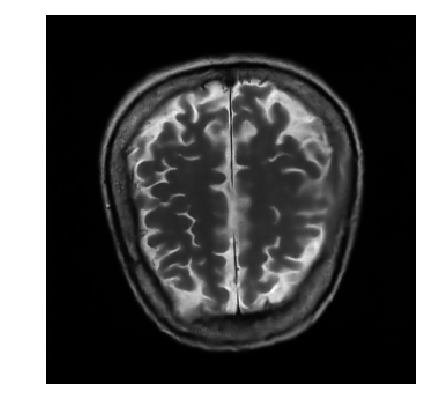

In [393]:
show_image(output3)

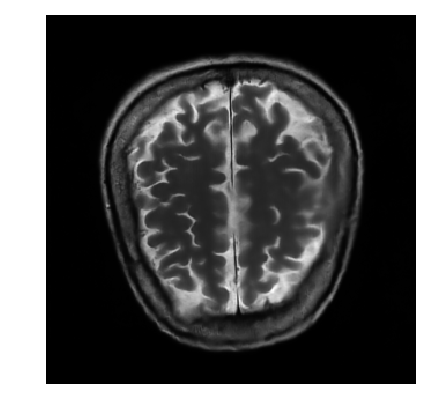

In [392]:
show_image(output2)

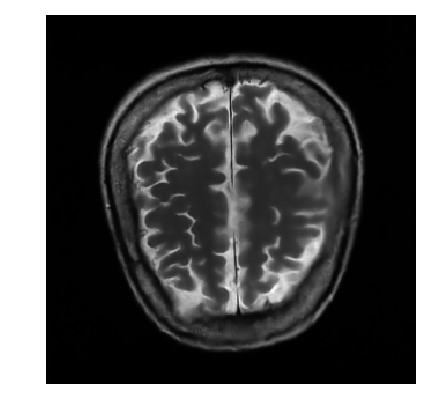

In [391]:
show_image(output1)

In [ ]:
evaluate(args_Unet_with_trajectory_learning, 1, Unet_with_trajectory_learning, dev_loader)

In [20]:
import torch
import torch.nn.functional as F
import numpy as np
import time
from tqdm import tqdm

def evaluate(args, model, data_loader, adv_norm = "l1", epsilon = None):
    losses = []
    psnr_l = []
    ssim_l = []

    start = time.perf_counter()
    progress_bar = tqdm(enumerate(data_loader), total=len(data_loader), desc=f"Evaluating")

    for iter, data in progress_bar:
        init_trajectory = model.module.get_trajectory().data
        input, target, mean, std, norm = data
        input = input.to(args.device)
        resolution = target.shape[-1]
        target = target.to(args.device)
        if epsilon != None:
            noisy_trajectory_l1 = pgd_attack_with_trajectory(model, input, target, epsilon, norm = adv_norm, steps=10)
            model.module.get_trajectory().data = noisy_trajectory_l1
        
        with torch.no_grad():
            output = model(input.unsqueeze(1))
            recons = output.to('cpu').squeeze(1).view(target.shape)
            recons = recons.squeeze()
            if output.shape != target.shape:
                target = target.view_as(output)

            loss = F.l1_loss(output, target)
            losses.append(loss.item()) 

            target = target.view(-1, resolution, resolution)
            recons = recons.view(target.shape)

            psnr_value = psnr(target.to('cpu').numpy(), recons.numpy())
            ssim_value = ssim(target.to('cpu').numpy(), recons.numpy())
            psnr_l.append(psnr_value)
            ssim_l.append(ssim_value)

            # Update tqdm progress bar with current metrics
            progress_bar.set_postfix({
                "Loss": f"{loss.item():.4f}",
                "PSNR": f"{psnr_value:.2f}",
                "SSIM": f"{ssim_value:.4f}"
            })
            model.module.get_trajectory().data = init_trajectory

    print(f'PSNR: {np.mean(psnr_l):.2f} ± {np.std(psnr_l):.2f}, SSIM: {np.mean(ssim_l):.4f} ± {np.std(ssim_l):.4f}')

    x = model.module.get_trajectory()
    v, a = get_vel_acc(x)
    acc_loss = torch.sqrt(torch.sum(torch.pow(F.softshrink(a, args.a_max), 2)))
    vel_loss = torch.sqrt(torch.sum(torch.pow(F.softshrink(v, args.v_max), 2)))
    rec_loss = np.mean(losses)

    return rec_loss, np.mean(psnr_l), np.mean(ssim_l)

In [11]:
import numpy as np
import torch
import json

def apply_noise(noise_type = "random"):
    noise_levels = np.logspace(3, 10, 11)
    for model_name, file in checkpoint_files.items():
        _, model, _, args = load_model(file)
        args.sample_rate = 0.25
        args.batch_size = 10
        test_loader = create_data_loaders(args)
        initial_trajectory = model.module.subsampling.x.clone()
        results = []

        for noise_level in noise_levels:
            print("noise_level: ", noise_level)
            model.module.subsampling.x.data = initial_trajectory
            #_, psnr_l1_adv, ssim_l1_adv = evaluate(args, model, test_loader, "l1", noise_level)
            #_, psnr_l2_adv, ssim_l2_adv = evaluate(args, model, test_loader, "l2", noise_level)
            
            l1_noise = torch.randn_like(initial_trajectory) if noise_type == "random" else torch.ones_like(initial_trajectory)
            l1_norm = torch.norm(l1_noise, p=1)
            l1_noise_scaled = noise_level * l1_noise / l1_norm 

            l2_noise = torch.randn_like(initial_trajectory) if noise_type == "random" else torch.ones_like(initial_trajectory)
            l2_norm = torch.norm(l2_noise)
            l2_noise_scaled = noise_level * l2_noise / l2_norm 

            noisy_trajectory_l1 = initial_trajectory + l1_noise_scaled
            noisy_trajectory_l1 = torch.clamp(noisy_trajectory_l1, min=-160, max=160)

            noisy_trajectory_l2 = initial_trajectory + l2_noise_scaled
            noisy_trajectory_l2 = torch.clamp(noisy_trajectory_l2, min=-160, max=160)
            
            noise_level_l1 = torch.norm(noisy_trajectory_l1 - initial_trajectory, p=1)
            noise_level_l2 = torch.norm(noisy_trajectory_l2 - initial_trajectory, p=2)
            
            print("noise_level_l1: ", noise_level_l1, "noise_level_l2: ", noise_level_l2)

            with torch.no_grad():
                model.module.subsampling.x.data = noisy_trajectory_l1
            dev_loss_l1, noisy_psnr_l1, noisy_ssim_l1, noisy_psnr_l1_s, noisy_ssim_l1_s = evaluate(args, 1, model, test_loader)

            with torch.no_grad():
                model.module.subsampling.x.data = noisy_trajectory_l2
            dev_loss_l2, noisy_psnr_l2, noisy_ssim_l2, noisy_psnr_l2_s, noisy_ssim_l2_s = evaluate(args, 1,model, test_loader)
            
            results.append({
                'noise_level_l1': float(noise_level_l1.item()),
                'noise_level_l2': float(noise_level_l2.item()),
                'psnr_l1': (noisy_psnr_l1, noisy_psnr_l1_s),
                'ssim_l1': (noisy_ssim_l1, noisy_ssim_l1_s),
                'psnr_l2': (noisy_psnr_l2, noisy_psnr_l2_s),
                'ssim_l2': (noisy_ssim_l2, noisy_ssim_l2_s),
            })


        with open(f'results_{model_name}_{noise_type}.json', 'w') as f:
            json.dump(results, f, indent=4)

In [12]:
apply_noise("ones")

/home/mohammed-wa/PycharmProjects/MPILOT/summary/16/radial_0.0001_0.075_0.001_0.001_changing_downwards_10_Unet_ones_constant_0_10000000.0_l1_p0.5/model.pt
reconstructing : Unet
3001
0
/home/mohammed-wa/PycharmProjects/MPILOT/Datasets/pd_only/multicoil_test
noise_level:  1000.0
noise_level_l1:  tensor(1058.6421, device='cuda:0', grad_fn=<NormBackward0>) noise_level_l2:  tensor(999.7285, device='cuda:0', grad_fn=<NormBackward0>)


Evaluating Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.20s/it, Loss=0.1734, PSNR=29.06, SSIM=0.7764]

PSNR: 28.46 ± 2.57, SSIM: 0.8068 ± 0.0365



Evaluating Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.20s/it, Loss=0.1774, PSNR=28.66, SSIM=0.7797]

PSNR: 28.12 ± 2.58, SSIM: 0.7997 ± 0.0381
noise_level:  5011.872336272725
noise_level_l1:  tensor(5068.3901, device='cuda:0', grad_fn=<NormBackward0>) noise_level_l2:  tensor(4997.5107, device='cuda:0', grad_fn=<NormBackward0>)



Evaluating Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.21s/it, Loss=0.1748, PSNR=28.88, SSIM=0.7789]

PSNR: 28.40 ± 2.57, SSIM: 0.8060 ± 0.0368



Evaluating Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.20s/it, Loss=0.2008, PSNR=27.56, SSIM=0.7485]

PSNR: 27.35 ± 2.64, SSIM: 0.7809 ± 0.0386
noise_level:  25118.864315095823
noise_level_l1:  tensor(25164.5254, device='cuda:0', grad_fn=<NormBackward0>) noise_level_l2:  tensor(24226.2969, device='cuda:0', grad_fn=<NormBackward0>)



Evaluating Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.19s/it, Loss=0.1879, PSNR=28.01, SSIM=0.7641]

PSNR: 27.74 ± 2.62, SSIM: 0.7919 ± 0.0383



Evaluating Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.19s/it, Loss=0.3345, PSNR=22.28, SSIM=0.6196]

PSNR: 20.28 ± 2.58, SSIM: 0.5618 ± 0.0557
noise_level:  125892.54117941661
noise_level_l1:  tensor(125882.3125, device='cuda:0', grad_fn=<NormBackward0>) noise_level_l2:  tensor(53592.4648, device='cuda:0', grad_fn=<NormBackward0>)



Evaluating Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:31<00:00,  2.27s/it, Loss=0.2027, PSNR=27.35, SSIM=0.7481]

PSNR: 27.45 ± 2.63, SSIM: 0.7844 ± 0.0414



Evaluating Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.21s/it, Loss=0.8640, PSNR=15.79, SSIM=0.3218]

PSNR: 16.20 ± 2.27, SSIM: 0.3448 ± 0.0266
noise_level:  630957.344480193
noise_level_l1:  tensor(630295.0625, device='cuda:0', grad_fn=<NormBackward0>) noise_level_l2:  tensor(53592.4648, device='cuda:0', grad_fn=<NormBackward0>)



Evaluating Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.19s/it, Loss=0.2194, PSNR=26.85, SSIM=0.7286]

PSNR: 27.36 ± 2.49, SSIM: 0.7797 ± 0.0406



Evaluating Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.18s/it, Loss=0.8640, PSNR=15.79, SSIM=0.3218]

PSNR: 16.20 ± 2.27, SSIM: 0.3448 ± 0.0266
noise_level:  3162277.6601683795
noise_level_l1:  tensor(3124533.2500, device='cuda:0', grad_fn=<NormBackward0>) noise_level_l2:  tensor(53592.4648, device='cuda:0', grad_fn=<NormBackward0>)



Evaluating Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.17s/it, Loss=0.2321, PSNR=26.02, SSIM=0.7210]

PSNR: 24.95 ± 2.68, SSIM: 0.7226 ± 0.0450



Evaluating Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.19s/it, Loss=0.8640, PSNR=15.79, SSIM=0.3218]

PSNR: 16.20 ± 2.27, SSIM: 0.3448 ± 0.0266
noise_level:  15848931.924611108
noise_level_l1:  tensor(13159085., device='cuda:0', grad_fn=<NormBackward0>) noise_level_l2:  tensor(53592.4648, device='cuda:0', grad_fn=<NormBackward0>)



Evaluating Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.20s/it, Loss=0.7834, PSNR=16.39, SSIM=0.2938]

PSNR: 16.64 ± 2.27, SSIM: 0.3392 ± 0.0270



Evaluating Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.19s/it, Loss=0.8640, PSNR=15.79, SSIM=0.3218]

PSNR: 16.20 ± 2.27, SSIM: 0.3448 ± 0.0266
noise_level:  79432823.47242805
noise_level_l1:  tensor(15376464., device='cuda:0', grad_fn=<NormBackward0>) noise_level_l2:  tensor(53592.4648, device='cuda:0', grad_fn=<NormBackward0>)



Evaluating Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.20s/it, Loss=0.8640, PSNR=15.79, SSIM=0.3218]

PSNR: 16.20 ± 2.27, SSIM: 0.3448 ± 0.0266



Evaluating Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.20s/it, Loss=0.8640, PSNR=15.79, SSIM=0.3218]

PSNR: 16.20 ± 2.27, SSIM: 0.3448 ± 0.0266
noise_level:  398107170.5534969
noise_level_l1:  tensor(15376464., device='cuda:0', grad_fn=<NormBackward0>) noise_level_l2:  tensor(53592.4648, device='cuda:0', grad_fn=<NormBackward0>)



Evaluating Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.19s/it, Loss=0.8640, PSNR=15.79, SSIM=0.3218]

PSNR: 16.20 ± 2.27, SSIM: 0.3448 ± 0.0266



Evaluating Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.18s/it, Loss=0.8640, PSNR=15.79, SSIM=0.3218]

PSNR: 16.20 ± 2.27, SSIM: 0.3448 ± 0.0266
noise_level:  1995262314.9688828
noise_level_l1:  tensor(15376464., device='cuda:0', grad_fn=<NormBackward0>) noise_level_l2:  tensor(53592.4648, device='cuda:0', grad_fn=<NormBackward0>)



Evaluating Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.18s/it, Loss=0.8640, PSNR=15.79, SSIM=0.3218]

PSNR: 16.20 ± 2.27, SSIM: 0.3448 ± 0.0266



Evaluating Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.20s/it, Loss=0.8640, PSNR=15.79, SSIM=0.3218]

PSNR: 16.20 ± 2.27, SSIM: 0.3448 ± 0.0266
noise_level:  10000000000.0
noise_level_l1:  tensor(15376464., device='cuda:0', grad_fn=<NormBackward0>) noise_level_l2:  tensor(53592.4648, device='cuda:0', grad_fn=<NormBackward0>)



Evaluating Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.19s/it, Loss=0.8640, PSNR=15.79, SSIM=0.3218]

PSNR: 16.20 ± 2.27, SSIM: 0.3448 ± 0.0266



Evaluating Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.16s/it, Loss=0.8640, PSNR=15.79, SSIM=0.3218]

PSNR: 16.20 ± 2.27, SSIM: 0.3448 ± 0.0266


TypeError: Object of type Tensor is not JSON serializable

results_Unet_with_trajectory_learning_with_constant_noise_10000_l1_0.2_ones.json contains 10 entries.
results_Unet_with_trajectory_learning_with_constant_noise_10000_l1_0.5_ones.json contains 10 entries.
results_Unet_with_trajectory_learning_with_linear_noise_1e6_l1_1_ones.json contains 10 entries.


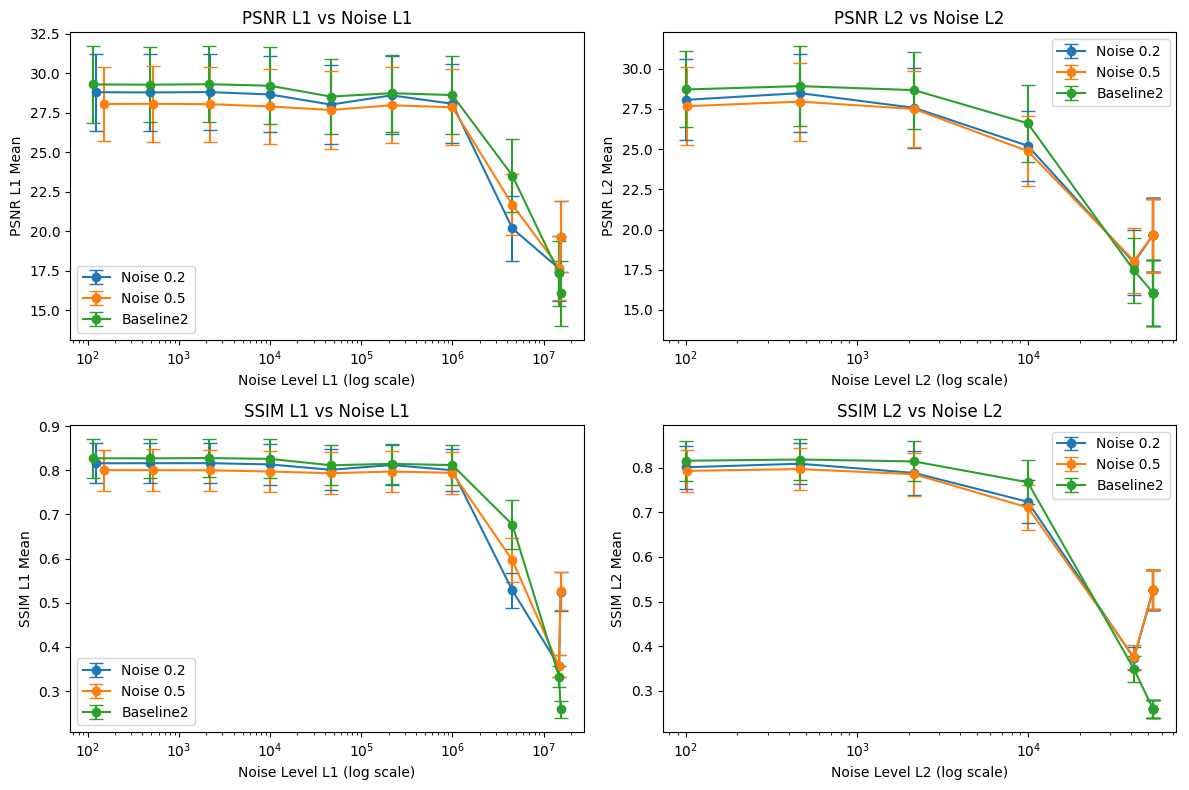

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import json

def load_json(file_name):
    """Load the JSON data from a file."""
    try:
        with open(file_name, 'r') as file:
            return json.load(file)
    except Exception as e:
        print(f"Error loading {file_name}: {e}")
        return []

# Manually enter the JSON file names with labels for the legend
json_files = [
    #("results_Unet_with_trajectory_learning_ones.json", "Baseline"),
    ("results_Unet_with_trajectory_learning_with_constant_noise_10000_l1_0.2_ones.json", "Noise 0.2"),
    ("results_Unet_with_trajectory_learning_with_constant_noise_10000_l1_0.5_ones.json", "Noise 0.5"),
    ("results_Unet_with_trajectory_learning_with_linear_noise_1e6_l1_1_ones.json", "Baseline2")
]

# Lists to store data from all files
file_data = []

# Load data from each file
for file_name, label in json_files:
    data = load_json(file_name)
    if not data:
        print(f"Skipping {file_name} due to empty or invalid data.")
        continue
    num_entries = len(data)
    print(f"{file_name} contains {num_entries} entries.")

    # Extract noise levels and metrics
    noise_l1 = np.array([entry.get('noise_level_l1', np.nan) for entry in data])
    noise_l2 = np.array([entry.get('noise_level_l2', np.nan) for entry in data])
    psnr_l1_means = np.array([entry.get('psnr_l1', [np.nan, np.nan])[0] for entry in data])
    psnr_l1_stds = np.array([entry.get('psnr_l1', [np.nan, np.nan])[1] for entry in data])
    psnr_l2_means = np.array([entry.get('psnr_l2', [np.nan, np.nan])[0] for entry in data])
    psnr_l2_stds = np.array([entry.get('psnr_l2', [np.nan, np.nan])[1] for entry in data])
    ssim_l1_means = np.array([entry.get('ssim_l1', [np.nan, np.nan])[0] for entry in data])
    ssim_l1_stds = np.array([entry.get('ssim_l1', [np.nan, np.nan])[1] for entry in data])
    ssim_l2_means = np.array([entry.get('ssim_l2', [np.nan, np.nan])[0] for entry in data])
    ssim_l2_stds = np.array([entry.get('ssim_l2', [np.nan, np.nan])[1] for entry in data])

    file_data.append({
        'label': label,
        'noise_l1': noise_l1,
        'noise_l2': noise_l2,
        'psnr_l1_means': psnr_l1_means,
        'psnr_l1_stds': psnr_l1_stds,
        'psnr_l2_means': psnr_l2_means,
        'psnr_l2_stds': psnr_l2_stds,
        'ssim_l1_means': ssim_l1_means,
        'ssim_l1_stds': ssim_l1_stds,
        'ssim_l2_means': ssim_l2_means,
        'ssim_l2_stds': ssim_l2_stds
    })

# Plotting
plt.figure(figsize=(12, 8))

# PSNR L1 vs Noise L1
plt.subplot(2, 2, 1)
for data in file_data:
    plt.errorbar(data['noise_l1'], data['psnr_l1_means'], yerr=data['psnr_l1_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('PSNR L1 vs Noise L1')
plt.xlabel('Noise Level L1 (log scale)')
plt.ylabel('PSNR L1 Mean')
plt.legend()

# PSNR L2 vs Noise L2
plt.subplot(2, 2, 2)
for data in file_data:
    plt.errorbar(data['noise_l2'], data['psnr_l2_means'], yerr=data['psnr_l2_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('PSNR L2 vs Noise L2')
plt.xlabel('Noise Level L2 (log scale)')
plt.ylabel('PSNR L2 Mean')
plt.legend()

# SSIM L1 vs Noise L1
plt.subplot(2, 2, 3)
for data in file_data:
    plt.errorbar(data['noise_l1'], data['ssim_l1_means'], yerr=data['ssim_l1_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('SSIM L1 vs Noise L1')
plt.xlabel('Noise Level L1 (log scale)')
plt.ylabel('SSIM L1 Mean')
plt.legend()

# SSIM L2 vs Noise L2
plt.subplot(2, 2, 4)
for data in file_data:
    plt.errorbar(data['noise_l2'], data['ssim_l2_means'], yerr=data['ssim_l2_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('SSIM L2 vs Noise L2')
plt.xlabel('Noise Level L2 (log scale)')
plt.ylabel('SSIM L2 Mean')
plt.legend()

plt.tight_layout()
plt.show()

results_baseline__ones.json contains 15 entries.
results_baseline_plus_constant_noise_from_10000000_with_p___0.5__ones.json contains 15 entries.
results_baseline_plus_constant_noise_from_10000000_with_p___1__ones.json contains 15 entries.


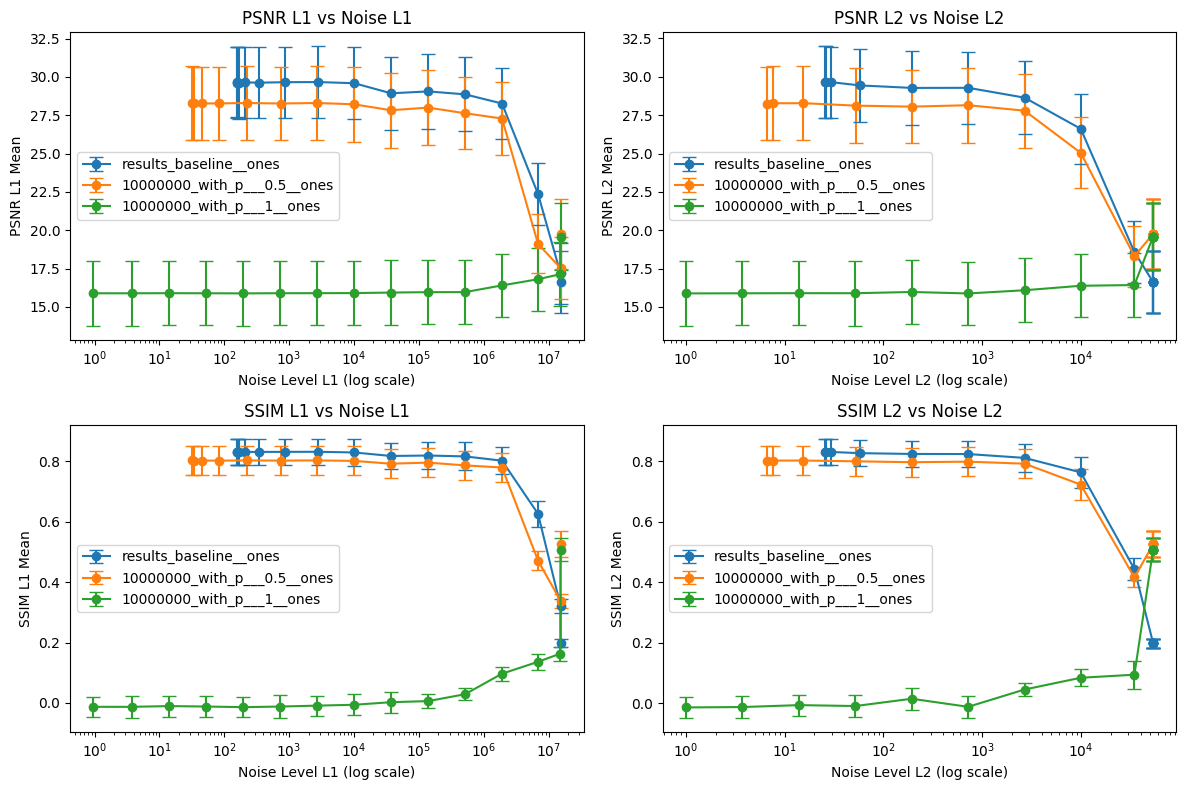

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import json

def load_json(file_name):
    """Load the JSON data from a file."""
    try:
        with open(file_name, 'r') as file:
            return json.load(file)
    except Exception as e:
        print(f"Error loading {file_name}: {e}")
        return []

# Manually enter the JSON file names with labels for the legend
json_files = [
    #("results_Unet_with_trajectory_learning_ones.json", "Baseline"),
    ("results_baseline__ones.json", "results_baseline__ones"),
    ("results_baseline_plus_constant_noise_from_10000000_with_p___0.5__ones.json", "10000000_with_p___0.5__ones"),
    ("results_baseline_plus_constant_noise_from_10000000_with_p___1__ones.json", "10000000_with_p___1__ones"),
]

# Lists to store data from all files
file_data = []

# Load data from each file
for file_name, label in json_files:
    data = load_json(file_name)
    if not data:
        print(f"Skipping {file_name} due to empty or invalid data.")
        continue
    num_entries = len(data)
    print(f"{file_name} contains {num_entries} entries.")

    # Extract noise levels and metrics
    noise_l1 = np.array([entry.get('noise_level_l1', np.nan) for entry in data])
    noise_l2 = np.array([entry.get('noise_level_l2', np.nan) for entry in data])
    psnr_l1_means = np.array([entry.get('psnr_l1', [np.nan, np.nan])[0] for entry in data])
    psnr_l1_stds = np.array([entry.get('psnr_l1', [np.nan, np.nan])[1] for entry in data])
    psnr_l2_means = np.array([entry.get('psnr_l2', [np.nan, np.nan])[0] for entry in data])
    psnr_l2_stds = np.array([entry.get('psnr_l2', [np.nan, np.nan])[1] for entry in data])
    ssim_l1_means = np.array([entry.get('ssim_l1', [np.nan, np.nan])[0] for entry in data])
    ssim_l1_stds = np.array([entry.get('ssim_l1', [np.nan, np.nan])[1] for entry in data])
    ssim_l2_means = np.array([entry.get('ssim_l2', [np.nan, np.nan])[0] for entry in data])
    ssim_l2_stds = np.array([entry.get('ssim_l2', [np.nan, np.nan])[1] for entry in data])

    file_data.append({
        'label': label,
        'noise_l1': noise_l1,
        'noise_l2': noise_l2,
        'psnr_l1_means': psnr_l1_means,
        'psnr_l1_stds': psnr_l1_stds,
        'psnr_l2_means': psnr_l2_means,
        'psnr_l2_stds': psnr_l2_stds,
        'ssim_l1_means': ssim_l1_means,
        'ssim_l1_stds': ssim_l1_stds,
        'ssim_l2_means': ssim_l2_means,
        'ssim_l2_stds': ssim_l2_stds
    })

# Plotting
plt.figure(figsize=(12, 8))

# PSNR L1 vs Noise L1
plt.subplot(2, 2, 1)
for data in file_data:
    plt.errorbar(data['noise_l1'], data['psnr_l1_means'], yerr=data['psnr_l1_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('PSNR L1 vs Noise L1')
plt.xlabel('Noise Level L1 (log scale)')
plt.ylabel('PSNR L1 Mean')
plt.legend()

# PSNR L2 vs Noise L2
plt.subplot(2, 2, 2)
for data in file_data:
    plt.errorbar(data['noise_l2'], data['psnr_l2_means'], yerr=data['psnr_l2_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('PSNR L2 vs Noise L2')
plt.xlabel('Noise Level L2 (log scale)')
plt.ylabel('PSNR L2 Mean')
plt.legend()

# SSIM L1 vs Noise L1
plt.subplot(2, 2, 3)
for data in file_data:
    plt.errorbar(data['noise_l1'], data['ssim_l1_means'], yerr=data['ssim_l1_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('SSIM L1 vs Noise L1')
plt.xlabel('Noise Level L1 (log scale)')
plt.ylabel('SSIM L1 Mean')
plt.legend()

# SSIM L2 vs Noise L2
plt.subplot(2, 2, 4)
for data in file_data:
    plt.errorbar(data['noise_l2'], data['ssim_l2_means'], yerr=data['ssim_l2_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('SSIM L2 vs Noise L2')
plt.xlabel('Noise Level L2 (log scale)')
plt.ylabel('SSIM L2 Mean')
plt.legend()

plt.tight_layout()
plt.show()

results_baseline__ones.json contains 15 entries.
results_baseline_plus_linear_noise_from_1e-06_to_1000000000_with_p___0.5__ones.json contains 15 entries.
results_baseline_plus_linear_noise_from_1e-08_to_100000000_with_p___0.5__ones.json contains 15 entries.


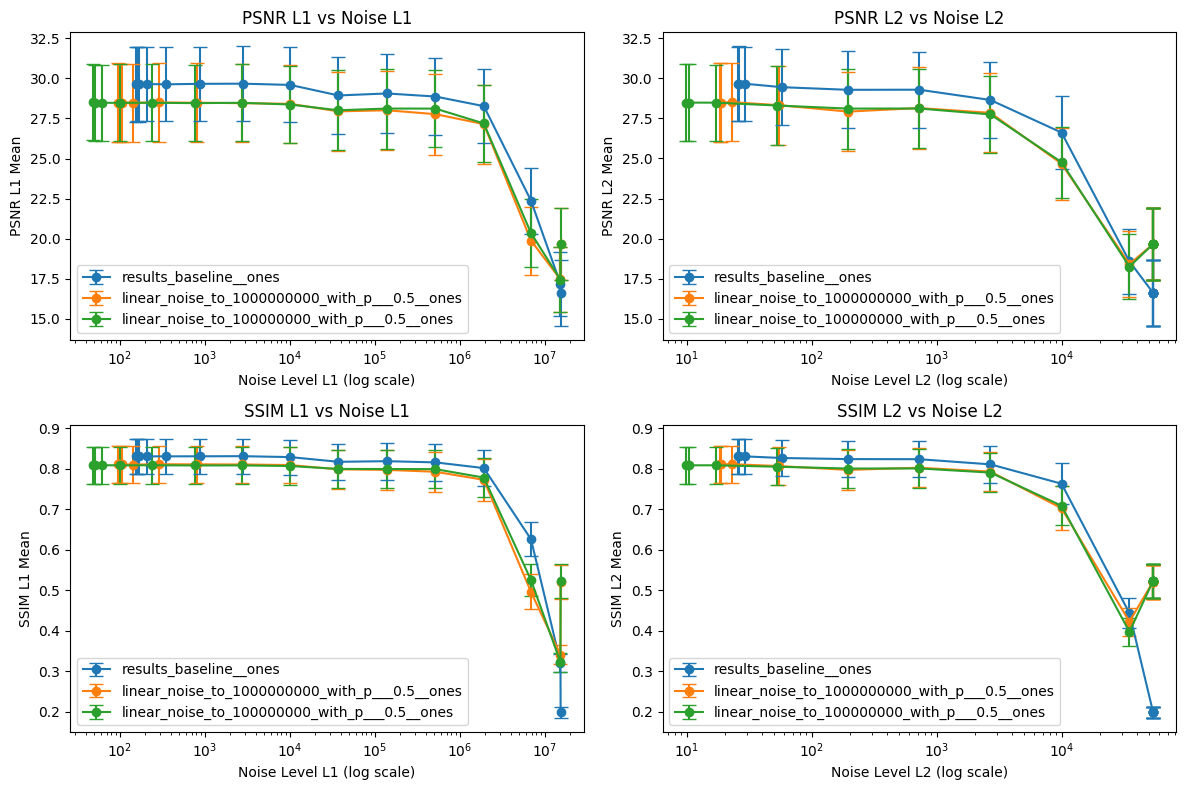

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import json

def load_json(file_name):
    """Load the JSON data from a file."""
    try:
        with open(file_name, 'r') as file:
            return json.load(file)
    except Exception as e:
        print(f"Error loading {file_name}: {e}")
        return []

# Manually enter the JSON file names with labels for the legend
json_files = [
    #("results_Unet_with_trajectory_learning_ones.json", "Baseline"),
    ("results_baseline__ones.json", "results_baseline__ones"),
    ("results_baseline_plus_linear_noise_from_1e-06_to_1000000000_with_p___0.5__ones.json","linear_noise_to_1000000000_with_p___0.5__ones"),
    ("results_baseline_plus_linear_noise_from_1e-08_to_100000000_with_p___0.5__ones.json","linear_noise_to_100000000_with_p___0.5__ones")
]

# Lists to store data from all files
file_data = []

# Load data from each file
for file_name, label in json_files:
    data = load_json(file_name)
    if not data:
        print(f"Skipping {file_name} due to empty or invalid data.")
        continue
    num_entries = len(data)
    print(f"{file_name} contains {num_entries} entries.")

    # Extract noise levels and metrics
    noise_l1 = np.array([entry.get('noise_level_l1', np.nan) for entry in data])
    noise_l2 = np.array([entry.get('noise_level_l2', np.nan) for entry in data])
    psnr_l1_means = np.array([entry.get('psnr_l1', [np.nan, np.nan])[0] for entry in data])
    psnr_l1_stds = np.array([entry.get('psnr_l1', [np.nan, np.nan])[1] for entry in data])
    psnr_l2_means = np.array([entry.get('psnr_l2', [np.nan, np.nan])[0] for entry in data])
    psnr_l2_stds = np.array([entry.get('psnr_l2', [np.nan, np.nan])[1] for entry in data])
    ssim_l1_means = np.array([entry.get('ssim_l1', [np.nan, np.nan])[0] for entry in data])
    ssim_l1_stds = np.array([entry.get('ssim_l1', [np.nan, np.nan])[1] for entry in data])
    ssim_l2_means = np.array([entry.get('ssim_l2', [np.nan, np.nan])[0] for entry in data])
    ssim_l2_stds = np.array([entry.get('ssim_l2', [np.nan, np.nan])[1] for entry in data])

    file_data.append({
        'label': label,
        'noise_l1': noise_l1,
        'noise_l2': noise_l2,
        'psnr_l1_means': psnr_l1_means,
        'psnr_l1_stds': psnr_l1_stds,
        'psnr_l2_means': psnr_l2_means,
        'psnr_l2_stds': psnr_l2_stds,
        'ssim_l1_means': ssim_l1_means,
        'ssim_l1_stds': ssim_l1_stds,
        'ssim_l2_means': ssim_l2_means,
        'ssim_l2_stds': ssim_l2_stds
    })

# Plotting
plt.figure(figsize=(12, 8))

# PSNR L1 vs Noise L1
plt.subplot(2, 2, 1)
for data in file_data:
    plt.errorbar(data['noise_l1'], data['psnr_l1_means'], yerr=data['psnr_l1_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('PSNR L1 vs Noise L1')
plt.xlabel('Noise Level L1 (log scale)')
plt.ylabel('PSNR L1 Mean')
plt.legend()

# PSNR L2 vs Noise L2
plt.subplot(2, 2, 2)
for data in file_data:
    plt.errorbar(data['noise_l2'], data['psnr_l2_means'], yerr=data['psnr_l2_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('PSNR L2 vs Noise L2')
plt.xlabel('Noise Level L2 (log scale)')
plt.ylabel('PSNR L2 Mean')
plt.legend()

# SSIM L1 vs Noise L1
plt.subplot(2, 2, 3)
for data in file_data:
    plt.errorbar(data['noise_l1'], data['ssim_l1_means'], yerr=data['ssim_l1_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('SSIM L1 vs Noise L1')
plt.xlabel('Noise Level L1 (log scale)')
plt.ylabel('SSIM L1 Mean')
plt.legend()

# SSIM L2 vs Noise L2
plt.subplot(2, 2, 4)
for data in file_data:
    plt.errorbar(data['noise_l2'], data['ssim_l2_means'], yerr=data['ssim_l2_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('SSIM L2 vs Noise L2')
plt.xlabel('Noise Level L2 (log scale)')
plt.ylabel('SSIM L2 Mean')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json

def load_json(file_name):
    """Load the JSON data from a file."""
    try:
        with open(file_name, 'r') as file:
            return json.load(file)
    except Exception as e:
        print(f"Error loading {file_name}: {e}")
        return []

# Manually enter the JSON file names with labels for the legend
json_files = [
    #("results_Unet_with_trajectory_learning_ones.json", "Baseline"),
    ("results_baseline__ones.json", "results_baseline__random"),
    ("results_baseline_plus_linear_noise_from_1e-06_to_1000000000_with_p___0.5__random.json","linear_noise_to_1000000000_with_p___0.5__random"),
    ("results_baseline_plus_linear_noise_from_1e-06_to_1000000000_with_p___0.1__random.json","linear_noise_to_1000000000_with_p___0.1__random"),
    ("results_baseline_plus_linear_noise_from_1e-08_to_100000000_with_p___0.5__random.json","linear_noise_to_100000000_with_p___0.5__random"),
]

# Lists to store data from all files
file_data = []

# Load data from each file
for file_name, label in json_files:
    data = load_json(file_name)
    if not data:
        print(f"Skipping {file_name} due to empty or invalid data.")
        continue
    num_entries = len(data)
    print(f"{file_name} contains {num_entries} entries.")

    # Extract noise levels and metrics
    noise_l1 = np.array([entry.get('noise_level_l1', np.nan) for entry in data])
    noise_l2 = np.array([entry.get('noise_level_l2', np.nan) for entry in data])
    psnr_l1_means = np.array([entry.get('psnr_l1', [np.nan, np.nan])[0] for entry in data])
    psnr_l1_stds = np.array([entry.get('psnr_l1', [np.nan, np.nan])[1] for entry in data])
    psnr_l2_means = np.array([entry.get('psnr_l2', [np.nan, np.nan])[0] for entry in data])
    psnr_l2_stds = np.array([entry.get('psnr_l2', [np.nan, np.nan])[1] for entry in data])
    ssim_l1_means = np.array([entry.get('ssim_l1', [np.nan, np.nan])[0] for entry in data])
    ssim_l1_stds = np.array([entry.get('ssim_l1', [np.nan, np.nan])[1] for entry in data])
    ssim_l2_means = np.array([entry.get('ssim_l2', [np.nan, np.nan])[0] for entry in data])
    ssim_l2_stds = np.array([entry.get('ssim_l2', [np.nan, np.nan])[1] for entry in data])

    file_data.append({
        'label': label,
        'noise_l1': noise_l1,
        'noise_l2': noise_l2,
        'psnr_l1_means': psnr_l1_means,
        'psnr_l1_stds': psnr_l1_stds,
        'psnr_l2_means': psnr_l2_means,
        'psnr_l2_stds': psnr_l2_stds,
        'ssim_l1_means': ssim_l1_means,
        'ssim_l1_stds': ssim_l1_stds,
        'ssim_l2_means': ssim_l2_means,
        'ssim_l2_stds': ssim_l2_stds
    })

# Plotting
plt.figure(figsize=(12, 8))

# PSNR L1 vs Noise L1
plt.subplot(2, 2, 1)
for data in file_data:
    plt.errorbar(data['noise_l1'], data['psnr_l1_means'], yerr=data['psnr_l1_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('PSNR L1 vs Noise L1')
plt.xlabel('Noise Level L1 (log scale)')
plt.ylabel('PSNR L1 Mean')
plt.legend()

# PSNR L2 vs Noise L2
plt.subplot(2, 2, 2)
for data in file_data:
    plt.errorbar(data['noise_l2'], data['psnr_l2_means'], yerr=data['psnr_l2_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('PSNR L2 vs Noise L2')
plt.xlabel('Noise Level L2 (log scale)')
plt.ylabel('PSNR L2 Mean')
plt.legend()

# SSIM L1 vs Noise L1
plt.subplot(2, 2, 3)
for data in file_data:
    plt.errorbar(data['noise_l1'], data['ssim_l1_means'], yerr=data['ssim_l1_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('SSIM L1 vs Noise L1')
plt.xlabel('Noise Level L1 (log scale)')
plt.ylabel('SSIM L1 Mean')
plt.legend()

# SSIM L2 vs Noise L2
plt.subplot(2, 2, 4)
for data in file_data:
    plt.errorbar(data['noise_l2'], data['ssim_l2_means'], yerr=data['ssim_l2_stds'], 
                 fmt='o-', capsize=5, label=data['label'])
plt.xscale('log')
plt.title('SSIM L2 vs Noise L2')
plt.xlabel('Noise Level L2 (log scale)')
plt.ylabel('SSIM L2 Mean')
plt.legend()

plt.tight_layout()
plt.show()